# Projet Fixmatch

In [1]:
!pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [2]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
# from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
from torchvision import transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

# os
import os
import path

import random
import numpy as np 

# transformations
# import transform as T
# from randaugment import RandomAugment

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

from randaugment import RandAugmentMC

%load_ext autoreload
%autoreload 2

In [3]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [4]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [5]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.9 #! 0.95 in the paper
LAMBDA_U = 3
MU = 4
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001
BETA_DENSITY = 1

In [6]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)
        # x = self.softmax(x)

        return x

In [16]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean+= torch.mean(images, dim=[0,2,3])
        std+= torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.4913966  0.48215377 0.44651437], std: [0.246344   0.24280126 0.26067406]
Files already downloaded and verified


In [8]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## IV. Semi-Supervised Learning: Fixmatch with Active Learning

### IV.1 Fixmatch on 10% train data with Active Learning

In [17]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

TARGET_PROP = 0.05
EPOCHS = 300
SUBSET_PROP = 0.01
EPOCHS_AL = 50
K_SAMPLES = int ( (TARGET_PROP * len(trainset) - SUBSET_PROP * len(trainset)) / EPOCHS_AL )

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# indices of labeled data
labeled_indices = trainset_sup.indices

# indices of unlabeled data
unlabeled_indices = trainset_unsup.indices

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [10]:
# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
    

In [11]:
def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

In [12]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')
true_unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS//3, eta_min=0, last_epoch=-1)

In [13]:
def information_density(
    model: ConvNN, 
    inputs: torch.Tensor,
    k_samp: int,
    K_transform: int = 5) -> torch.Tensor:

    qb_transformed = torch.zeros((K_transform, inputs.shape[0], 10))
    with torch.no_grad():
        for k in range(K_transform):
            # compute weak transformation of inputs norm
            weak_transformed_inputs = weak_transform(inputs)

            # normalize
            # weak_transformed_inputs_norm = normalize(data=weak_transformed_inputs, mean=mean, std=std)

            # compute predictions of weak transformed inputs norm
            logits = model(weak_transformed_inputs)
            qb = torch.softmax(logits, dim=1)

            # store
            qb_transformed[k] = qb
    
    # compute mean
    qb = torch.mean(qb_transformed, dim=0)

    # get top 2 values of qb
    qb1, qb2 = torch.topk(qb, k=2, dim=1)[0][:, 0], torch.topk(qb, k=2, dim=1)[0][:, 1]

    uncertainty = qb1 - qb2

    # get top k_samp indices
    _, idx = torch.topk(uncertainty, k=k_samp, dim=0)

    return idx

# Create a new labeled dataset using active learning
def create_labeled_dataset_active_learning(dataset, selected_indices):
    labeled_dataset = torch.utils.data.Subset(dataset, selected_indices)
    return labeled_dataset

In [14]:
print("Start training")

current_prop = SUBSET_PROP

train_losses = []
test_losses = []
added_samp = 0

for j in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {j: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, unlabeled_labels = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        

        # Zero the parameter gradients
        optimizer.zero_grad()

        # normalize labeled and unlabeled inputs
        # labeled_inputs_norm = normalize(data=labeled_inputs, mean=mean, std=std)
        # unlabeled_inputs_norm = normalize(data=unlabeled_inputs, mean=mean, std=std)

        # # Forward pass 
        # labeled_outputs_norm = model(labeled_inputs_norm)
        # unlabeled_outputs_norm = model(unlabeled_inputs_norm)

        # Compute moving average of labeled and unlabeled predictions
        # moving_avg_pred_labeled = (i * moving_avg_pred_labeled + labeled_outputs_norm.shape[0]) / (i + 1)
        # moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        # ratio = moving_avg_pred_labeled / moving_avg_pred_unlabeled

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        # weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        # weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        # strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # prediction on weak augmented unlabeled data
        # qb = model(weak_unlabeled_inputs)
        # qb = torch.softmax(qb, dim=1)
        # qb_norm = qb * ratio

        # # normalize
        # qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # # compute mask
        # max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        # idx = max_qb_tilde > TAU

        # # pseudo labels
        # pseudo_labels = qb_tilde_hat[idx]

        # # mask strong augmented unlabeled data
        # strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        # n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]
        unlabeled_labels = unlabeled_labels[idx]

        # if j >= 50 and j <= 50 + EPOCHS_AL:
        #     n_unlabeled = 0
        # else:
        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)
            true_unlabeled_loss = torch.sum(true_unlabeled_criterion(unlabeled_outputs, unlabeled_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)
            true_unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        
        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled 

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "true unlabeled loss": true_unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb).item(),
            "n_unlabeled": running_n_unlabeled,
            "current_prop": current_prop,
            "lr": optimizer.param_groups[0]['lr']
        })

    # start adding labels after 50 epochs for 50 epochs
    if j >= 50 and j <= 50 + EPOCHS_AL:
        if current_prop < TARGET_PROP:
            # compute information density
            selected_indices = information_density(model, unlabeled_inputs, K_SAMPLES)

            # select indices from unlabeled dataset
            trainset_sup_new = create_labeled_dataset_active_learning(trainset_unsup, selected_indices)

            # concat new trainset with labeled trainset
            trainset_sup = torch.utils.data.ConcatDataset([trainset_sup, trainset_sup_new])

            # create labeled dataloader
            labeled_dataloader = torch.utils.data.DataLoader(trainset_sup, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

            current_prop = len(trainset_sup) / len(trainset)

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    # if n_unlabeled != 0:
    #     # plot an image of the batch
    #     image = strong_unlabeled_inputs[0].cpu()
    #     # image = image * std + mean
    #     image = image.permute(1, 2, 0).cpu().numpy() * std + mean
    #     plt.imshow(image)
    #     plt.title(f'Pred: {unlabeled_outputs.argmax(dim=1)[0]}, true: {unlabeled_labels[0]}')
    #     plt.show()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)

Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 13.63%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 19.32%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 19.67%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 21.32%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 21.66%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 22.93%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.1%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.29%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 29.06%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.01%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.85%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.35%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.24%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.98%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.85%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.07%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.63%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.32%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.88%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.26%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.22%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.12%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.68%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.69%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.09%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.15%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.21%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.76%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.92%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.17%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.56%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.58%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.12%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.84%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.65%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.75%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.59%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.67%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.65%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.1%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.72%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.43%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.9%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.78%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.96%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.21%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.64%


Epoch    50:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.63%


Epoch    51:   0%|          | 0/9 [00:00<?, ?batch/s]

Test Accuracy: 39.9%


Epoch    52:   0%|          | 0/10 [00:00<?, ?batch/s]

Test Accuracy: 38.63%


Epoch    53:   0%|          | 0/10 [00:00<?, ?batch/s]

Test Accuracy: 42.6%


Epoch    54:   0%|          | 0/11 [00:00<?, ?batch/s]

Test Accuracy: 39.59%


Epoch    55:   0%|          | 0/11 [00:00<?, ?batch/s]

Test Accuracy: 42.19%


Epoch    56:   0%|          | 0/12 [00:00<?, ?batch/s]

Test Accuracy: 43.44%


Epoch    57:   0%|          | 0/13 [00:00<?, ?batch/s]

Test Accuracy: 42.44%


Epoch    58:   0%|          | 0/13 [00:00<?, ?batch/s]

Test Accuracy: 43.95%


Epoch    59:   0%|          | 0/14 [00:00<?, ?batch/s]

Test Accuracy: 41.82%


Epoch    60:   0%|          | 0/15 [00:00<?, ?batch/s]

Test Accuracy: 43.89%


Epoch    61:   0%|          | 0/15 [00:00<?, ?batch/s]

Test Accuracy: 45.0%


Epoch    62:   0%|          | 0/16 [00:00<?, ?batch/s]

Test Accuracy: 41.69%


Epoch    63:   0%|          | 0/16 [00:00<?, ?batch/s]

Test Accuracy: 43.01%


Epoch    64:   0%|          | 0/17 [00:00<?, ?batch/s]

Test Accuracy: 43.79%


Epoch    65:   0%|          | 0/18 [00:00<?, ?batch/s]

Test Accuracy: 43.22%


Epoch    66:   0%|          | 0/18 [00:00<?, ?batch/s]

Test Accuracy: 44.96%


Epoch    67:   0%|          | 0/19 [00:00<?, ?batch/s]

Test Accuracy: 44.25%


Epoch    68:   0%|          | 0/20 [00:00<?, ?batch/s]

Test Accuracy: 41.64%


Epoch    69:   0%|          | 0/20 [00:00<?, ?batch/s]

Test Accuracy: 44.85%


Epoch    70:   0%|          | 0/21 [00:00<?, ?batch/s]

Test Accuracy: 45.08%


Epoch    71:   0%|          | 0/21 [00:00<?, ?batch/s]

Test Accuracy: 44.32%


Epoch    72:   0%|          | 0/22 [00:00<?, ?batch/s]

Test Accuracy: 45.31%


Epoch    73:   0%|          | 0/23 [00:00<?, ?batch/s]

Test Accuracy: 43.83%


Epoch    74:   0%|          | 0/23 [00:00<?, ?batch/s]

Test Accuracy: 45.4%


Epoch    75:   0%|          | 0/24 [00:00<?, ?batch/s]

Test Accuracy: 45.72%


Epoch    76:   0%|          | 0/25 [00:00<?, ?batch/s]

Test Accuracy: 44.14%


Epoch    77:   0%|          | 0/25 [00:00<?, ?batch/s]

Test Accuracy: 45.38%


Epoch    78:   0%|          | 0/26 [00:00<?, ?batch/s]

Test Accuracy: 43.38%


Epoch    79:   0%|          | 0/26 [00:00<?, ?batch/s]

Test Accuracy: 45.86%


Epoch    80:   0%|          | 0/27 [00:00<?, ?batch/s]

Test Accuracy: 46.67%


Epoch    81:   0%|          | 0/28 [00:00<?, ?batch/s]

Test Accuracy: 46.6%


Epoch    82:   0%|          | 0/28 [00:00<?, ?batch/s]

Test Accuracy: 47.25%


Epoch    83:   0%|          | 0/29 [00:00<?, ?batch/s]

Test Accuracy: 47.31%


Epoch    84:   0%|          | 0/30 [00:00<?, ?batch/s]

Test Accuracy: 46.65%


Epoch    85:   0%|          | 0/30 [00:00<?, ?batch/s]

Test Accuracy: 46.95%


Epoch    86:   0%|          | 0/31 [00:00<?, ?batch/s]

Test Accuracy: 47.34%


Epoch    87:   0%|          | 0/31 [00:00<?, ?batch/s]

Test Accuracy: 47.25%


Epoch    88:   0%|          | 0/32 [00:00<?, ?batch/s]

Test Accuracy: 47.25%


Epoch    89:   0%|          | 0/33 [00:00<?, ?batch/s]

Test Accuracy: 47.91%


Epoch    90:   0%|          | 0/33 [00:00<?, ?batch/s]

Test Accuracy: 47.79%


Epoch    91:   0%|          | 0/34 [00:00<?, ?batch/s]

Test Accuracy: 47.56%


Epoch    92:   0%|          | 0/35 [00:00<?, ?batch/s]

Test Accuracy: 47.89%


Epoch    93:   0%|          | 0/35 [00:00<?, ?batch/s]

Test Accuracy: 47.84%


Epoch    94:   0%|          | 0/36 [00:00<?, ?batch/s]

Test Accuracy: 47.92%


Epoch    95:   0%|          | 0/36 [00:00<?, ?batch/s]

Test Accuracy: 48.06%


Epoch    96:   0%|          | 0/37 [00:00<?, ?batch/s]

Test Accuracy: 48.04%


Epoch    97:   0%|          | 0/38 [00:00<?, ?batch/s]

Test Accuracy: 48.15%


Epoch    98:   0%|          | 0/38 [00:00<?, ?batch/s]

Test Accuracy: 48.22%


Epoch    99:   0%|          | 0/39 [00:00<?, ?batch/s]

Test Accuracy: 48.18%


Epoch   100:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.18%


Epoch   101:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.14%


Epoch   102:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.21%


Epoch   103:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.06%


Epoch   104:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.27%


Epoch   105:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.42%


Epoch   106:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.84%


Epoch   107:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.31%


Epoch   108:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.09%


Epoch   109:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.5%


Epoch   110:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.36%


Epoch   111:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.17%


Epoch   112:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.37%


Epoch   113:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.35%


Epoch   114:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.17%


Epoch   115:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.47%


Epoch   116:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.56%


Epoch   117:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.27%


Epoch   118:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.74%


Epoch   119:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.12%


Epoch   120:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.92%


Epoch   121:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.6%


Epoch   122:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.48%


Epoch   123:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.32%


Epoch   124:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.86%


Epoch   125:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.7%


Epoch   126:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.19%


Epoch   127:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.69%


Epoch   128:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.16%


Epoch   129:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.4%


Epoch   130:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.72%


Epoch   131:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.75%


Epoch   132:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.84%


Epoch   133:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.56%


Epoch   134:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.13%


Epoch   135:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.49%


Epoch   136:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.98%


Epoch   137:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.57%


Epoch   138:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.49%


Epoch   139:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.21%


Epoch   140:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.91%


Epoch   141:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.53%


Epoch   142:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.18%


Epoch   143:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.1%


Epoch   144:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.55%


Epoch   145:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.65%


Epoch   146:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.67%


Epoch   147:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.95%


Epoch   148:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.02%


Epoch   149:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 43.96%


Epoch   150:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.78%


Epoch   151:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.92%


Epoch   152:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.71%


Epoch   153:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.73%


Epoch   154:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.84%


Epoch   155:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.95%


Epoch   156:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.77%


Epoch   157:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.81%


Epoch   158:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.55%


Epoch   159:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.27%


Epoch   160:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.02%


Epoch   161:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.78%


Epoch   162:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.42%


Epoch   163:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.81%


Epoch   164:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.93%


Epoch   165:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.47%


Epoch   166:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.61%


Epoch   167:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.24%


Epoch   168:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.35%


Epoch   169:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.0%


Epoch   170:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.62%


Epoch   171:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.55%


Epoch   172:   0%|          | 0/40 [00:00<?, ?batch/s]

KeyboardInterrupt: 

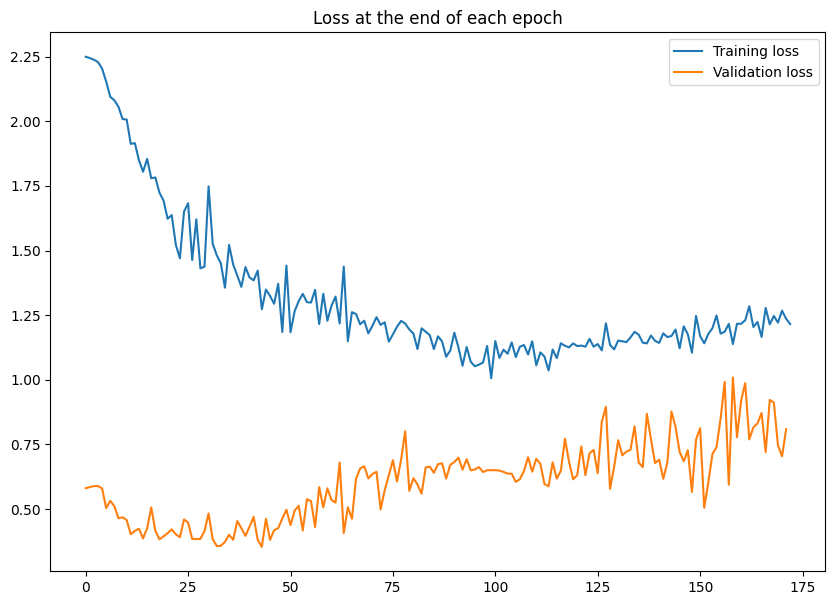

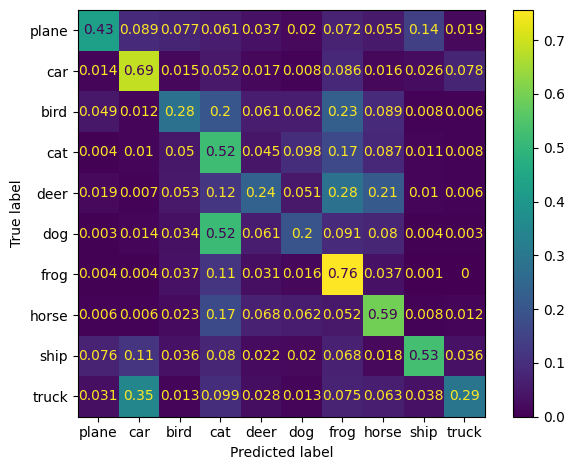

In [15]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch_AL.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(TARGET_PROP*100)}% - {test_accuracy:.2f}% - Active Learning")
fig1.savefig(f"./figures/test_score_{TARGET_PROP}_fixmatch_AL.png")

### III.2 Fixmatch on 5% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.05

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")

### III.3 Fixmatch on 1% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.01

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")